In [1]:
# Does numerical search over lens focal length, defocus, and compares subaperture shapes 
# to find best coupling

# Created 2023 Apr. 17 by E.S.

In [1]:
import poppy
import pickle
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [2]:
stem = '/Users/bandari/Documents/git.repos/glint_misc/notebooks/data/'

In [3]:
## BEGIN USER-DEFINED QUANTITIES

## LOOP THIS
# initial focal length of lens (um) in the substrate
f_lens_substr = 284.664*u.micron

# pixel scale of 'detector' image (plane of waveguide entrance)
scale_wg = 0.2161*u.micron/u.pix

## REVISIT
# lenslet diameter
diam_lenslet = 66.*u.micron

# index of refraction of substrate
n_glass = 1.5255

## LOOP THIS
# wavelength in air (n = 1)
wavel_air = 1.55*u.micron

## END USER-DEFINED QUANTITIES

In [4]:
file_names_waveguide_modes = [stem + 'AF45_100x_Zeiss_300um_1550nm_1000mmmin_67pt5nJ_csv.pkl', 
                              stem + 'AF45_100x_Zeiss_300um_1550nm_1000mmmin_77pt5nJ_csv.pkl',
                              stem + 'AF45_100x_Zeiss_300um_1550nm_2000mmmin_67pt5nJ_csv.pkl',
                              stem + 'AF45_100x_Zeiss_300um_1550nm_500mmmin_75nJ_csv.pkl', 
                              stem + 'AF45_100x_Zeiss_300um_1550nm_750mmmin_50nJ_csv.pkl', 
                              stem + 'AF45_100x_Zeiss_300um_1550nm_750mmmin_77pt5nJ_csv.pkl']

In [8]:
# derived quantities

# wavelength in substrate
WAVEL_SUBSTR = (wavel_air/n_glass)

# radius of first dark ring in um
circ_r_um = 1.22 * wavel_substr * f_lens_substr/diam_lenslet

## LOOP THIS
file_name_wg = file_names_waveguide_modes[0]

print('radius of first dark Airy ring (um):',circ_r_um)

radius of first dark Airy ring (um): 5.346479783081552 micron


In [6]:
# set scale of apertures of all modeled subaperture shapes

# pixel scale in terms of arcsec/pix
pixelscale_ang = (scale_wg/f_lens_substr)*206265.*u.arcsec # (0.2161um/f [um] )*206265 arcsec /pix

# 44600 arcsec FOV means 40 um on each edge (defunct?)
#FOV = 44600*u.arcsec

In [7]:
# read in waveguide mode

'''
S. Gross:

The waveguide modes have a 4sigma diameter of 8.3x7.6um. 
A simple Gaussian fit gives a 1/e2 diameter of 5.8x5.4um. 
Both at a wavelength of 1550nm.

The attached CSV file contains the corresponding intensity profile. 
The scale is 0.2161um per pixel.
'''

# retrieve waveguide intensity and make cutout

open_file = open(file_name_wg, "rb")
df_intensity, xycen = pickle.load(open_file)
open_file.close()
# cutouts
buffer = 100 # pix
waveguide_cutout = df_intensity[int(xycen[1]-buffer):int(xycen[1]+buffer),int(xycen[0]-buffer):int(xycen[0]+buffer)]

## Circular pupil: set up optics and calculate PSF (focal length implicit)

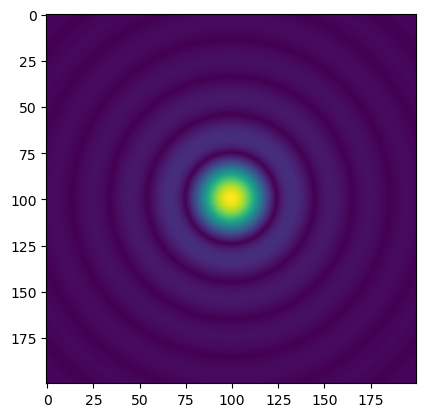

In [14]:
# circular pupil

steps_one_side = 50 # number of steps on one side of zero focus
overl_int_array = np.nan*np.ones(int(2*steps_one_side)) # will collect overlap integrals
defocus_values_array = np.nan*np.ones(int(2*steps_one_side)) # will collect defocus values (ito waves)
idx_accum = 0 # initialize index

## LOOP THIS
for step_foc in range(0,1): # -int(steps_one_side),int(steps_one_side)):
    
    NWAVES = step_foc*0.1 # size of defocus ito waves

    # construct system: Fraunhofer
    '''
    osys_circ = poppy.OpticalSystem()

    # lenslet
    lens = osys_circ.add_pupil(optic = poppy.ThinLens(name='lenslet', nwaves=NWAVES, radius=diam_lenslet))

    # final focal plane
    det = osys_circ.add_detector(pixelscale=pixelscale_ang, fov_pixels=100)  # image plane coordinates in arcseconds

    # see transmittance
    #osys_circ.display()

    #poppy.display_psf(psf)

    psf, all_wfs = osys_circ.calc_psf(wavelength=WAVEL_SUBSTR, 
                             display_intermediates=False,
                             return_intermediates=True)
    '''

    # define fields for overlap integral (should just be 200x200 arrays)
    input_field = all_wfs[1].amplitude * np.exp(1j*all_wfs[1].phase)
    mode_field = np.sqrt(waveguide_cutout) # sqrt because cutout is the intensity I, and we want E
    
    # check scaling is right
    plt.imshow(all_wfs[1].amplitude)
    plt.show()
    
    '''
    # overlap integral
    overlap_int_complex = np.sum(input_field*mode_field) / np.sqrt( np.sum(np.abs(mode_field)**2) * np.sum(np.abs(input_field)**2) )
    overlap_int = np.abs(overlap_int_complex)**2
    
    # print params
    print('---------------------')
    print('Defocus (waves):',NWAVES)
    print('Wavel in substrate (um):',WAVEL_SUBSTR)
    
    
    print('OVERLAP INTEGRAL:',overlap_int)
    
    overl_int_array[idx_accum] = overlap_int
    defocus_values_array[idx_accum] = NWAVES
    
    idx_accum += 1
    '''

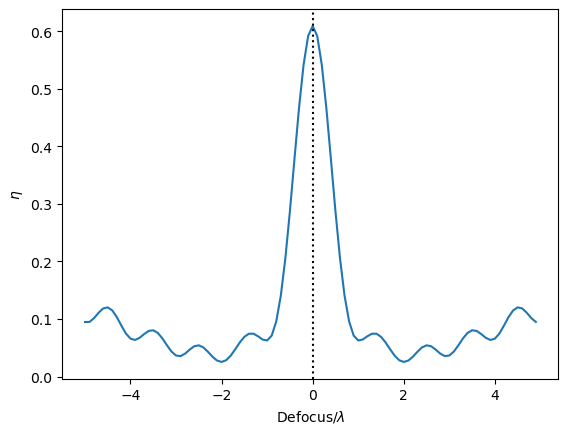

In [13]:
plt.plot(defocus_values_array,overl_int_array)
plt.axvline(x=0,linestyle=':',color='k')
plt.xlabel('Defocus/$\lambda$')
plt.ylabel('$\eta$')
plt.savefig('junk.png')

In [17]:
# intensities for plotting
I_PSF_circ = all_wfs[1].intensity

In [18]:
# for secondary physical axes: 0.2161um per pixel.
def pix2um(x):
    return x*0.2161

def um2pix(x):
    return x/0.2161

In [19]:
# radius of first dark ring in um
wavel = 1.55/1.5255 # um # 1.55 um in air, 1.55um/n = 1.55um/1.5255 = 1.016 um in substrate of index of refraction n
foc_length = 284.664 # 
D = 66 # um

circ_r_um = 1.22 * wavel * foc_length/D
circ_r_pix = um2pix(circ_r_um)

print('radius of first dark Airy ring (um):',circ_r_um)

# define circle for scale in plots
circ_cen_x = 0
circ_cen_y = 0 
circ1 = Circle((circ_cen_x,circ_cen_y),radius=circ_r_pix,color='white',fill=False)
circ2 = Circle((circ_cen_x,circ_cen_y),radius=circ_r_pix,color='white',fill=False)
circ3 = Circle((circ_cen_x,circ_cen_y),radius=circ_r_pix,color='white',fill=False)

radius of first dark Airy ring (um): 5.346479783081552


"\nsecax = ax[0,2].secondary_xaxis('top', functions=(pix2um, um2pix))\nsecax.set_xlabel('physical (um)')\nsecay = ax[0,2].secondary_yaxis('right', functions=(pix2um, um2pix))\nsecay.set_ylabel('physical (um)')\n"

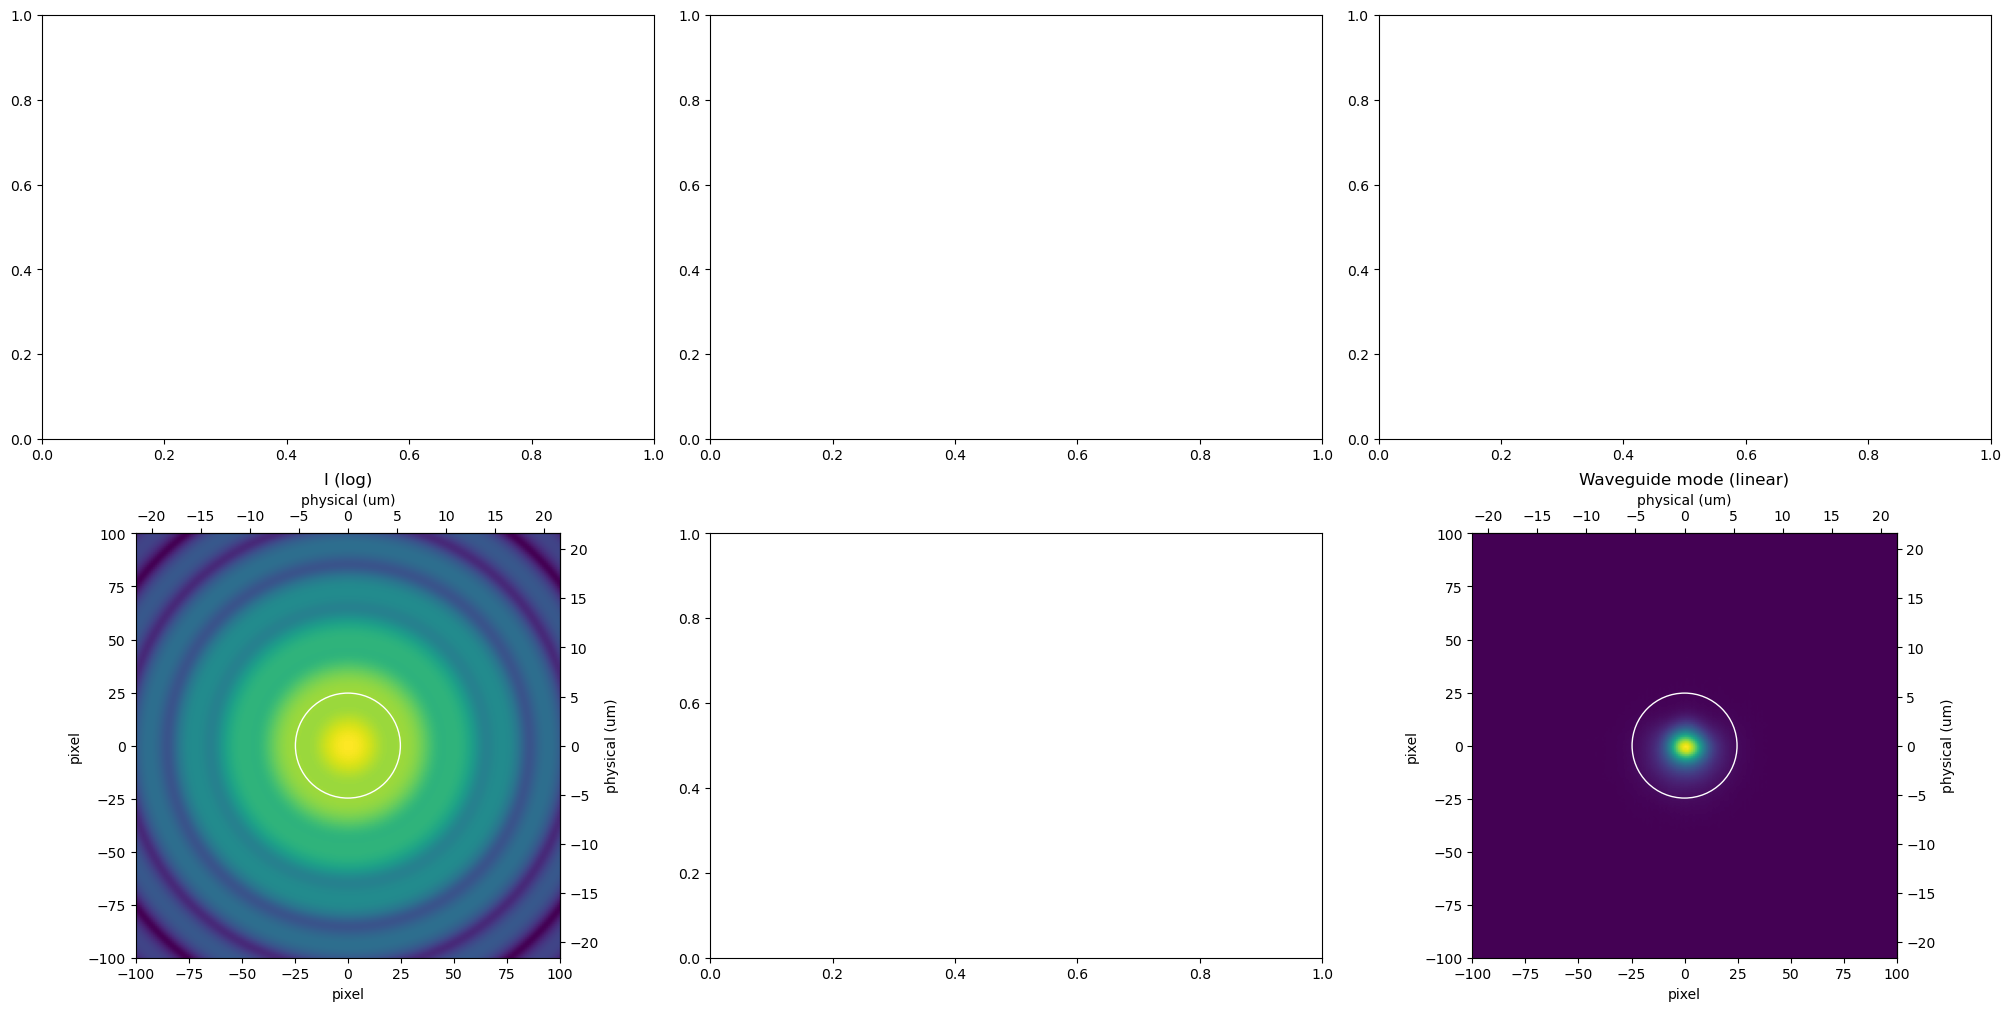

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10), layout='constrained')

'''
ax[0,0].set_title('Circular subap')
ax[0,0].imshow(circ_aperture_simple, cmap='Greys_r', interpolation='nearest')
ax[0,0].set_xlabel('(arbitrary)')
ax[0,0].set_ylabel('(arbitrary)')

ax[0,1].set_title('Hexagonal subap')
ax[0,1].imshow(hex_aperture_simple, cmap='Greys_r', interpolation='nearest')
ax[0,1].set_xlabel('(arbitrary)')

# show normalized profiles of everything
ax[0,2].plot(np.divide(I_PSF_circ[int(buffer),:],np.max(I_PSF_circ[int(buffer),:])),color='red',label='circle')
ax[0,2].plot(np.divide(I_PSF_hex[int(buffer),:],np.max(I_PSF_hex[int(buffer),:])),color='blue',label='hexagon')
ax[0,2].plot(np.divide(waveguide_cutout[int(buffer),:],np.max(waveguide_cutout[int(buffer),:])),color='green',label='waveguide mode')
ax[0,2].legend()
'''
ax[1,0].set_title('I (log)')
ax[1,0].imshow(I_PSF_circ, extent=[-I_PSF_circ.shape[1]/2., I_PSF_circ.shape[1]/2., -I_PSF_circ.shape[0]/2., I_PSF_circ.shape[0]/2. ], alpha=1, norm='log')
ax[1,0].set_xlabel('pixel')
ax[1,0].set_ylabel('pixel')
ax[1,0].add_patch(circ1)
'''
#ax[1,1].imshow(waveguide_cutout, extent=[-waveguide_cutout.shape[1]/2., waveguide_cutout.shape[1]/2., -waveguide_cutout.shape[0]/2., waveguide_cutout.shape[0]/2. ], origin='lower')

ax[1,1].set_title('I (log)')
ax[1,1].imshow(I_PSF_hex, extent=[-waveguide_cutout.shape[1]/2., waveguide_cutout.shape[1]/2., -waveguide_cutout.shape[0]/2., waveguide_cutout.shape[0]/2. ], alpha=1, norm='log')
ax[1,1].set_xlabel('pixel')
ax[1,1].set_ylabel('pixel')
ax[1,1].add_patch(circ2)
'''
ax[1,2].set_title('Waveguide mode (linear)')
ax[1,2].imshow(waveguide_cutout, extent=[-waveguide_cutout.shape[1]/2., waveguide_cutout.shape[1]/2., -waveguide_cutout.shape[0]/2., waveguide_cutout.shape[0]/2. ], alpha=1)
ax[1,2].set_xlabel('pixel')
ax[1,2].set_ylabel('pixel')
ax[1,2].add_patch(circ3)

secax = ax[1,0].secondary_xaxis('top', functions=(pix2um, um2pix))
secax.set_xlabel('physical (um)')
secay = ax[1,0].secondary_yaxis('right', functions=(pix2um, um2pix))
secay.set_ylabel('physical (um)')
'''
secax = ax[1,1].secondary_xaxis('top', functions=(pix2um, um2pix))
secax.set_xlabel('physical (um)')
secay = ax[1,1].secondary_yaxis('right', functions=(pix2um, um2pix))
secay.set_ylabel('physical (um)')
'''
secax = ax[1,2].secondary_xaxis('top', functions=(pix2um, um2pix))
secax.set_xlabel('physical (um)')
secay = ax[1,2].secondary_yaxis('right', functions=(pix2um, um2pix))
secay.set_ylabel('physical (um)')
'''
secax = ax[0,2].secondary_xaxis('top', functions=(pix2um, um2pix))
secax.set_xlabel('physical (um)')
secay = ax[0,2].secondary_yaxis('right', functions=(pix2um, um2pix))
secay.set_ylabel('physical (um)')
'''


In [ ]:
# example code from BN

'''
psf, all_wfs = osys.calc_psf(wavelength=WAVELENGTH, display_intermediates=False,
                                             return_intermediates=True)
pupil_wf = all_wfs[2]
pupil_ampl = np.abs(pupil_wf.wavefront)
pupil_phase = pupil_wf.phase # One way to get phase

final_wf = all_wfs[-1]
psf_ampl = np.abs(final_wf.wavefront)
psf_phase = np.angle(final_wf.wavefront) # Aother way to get phase
'''